# Conditional GAN

Original paper: [Conditional Generative Adversarial Nets](https://arxiv.org/abs/1411.1784)

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms as T
from torch import nn
from torch.nn import functional as F

In [2]:
def one_hot(x, length=10):
    out = torch.zeros(length)
    out[x] = 1.
    return out

In [3]:
transform = T.Compose([
    T.ToTensor(),
    T.Normalize((0.5), (0.5)),
    T.Lambda(lambda x: torch.flatten(x)),
    ])
target_transform = T.Compose([
    T.Lambda(one_hot)
])

data = torchvision.datasets.MNIST(root="data/mnist", train=True, download=True,
                                        transform=transform, target_transform=target_transform)

In [4]:
img, label = data[0]
img.shape, label.shape, label

(torch.Size([784]),
 torch.Size([10]),
 tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]))

In [5]:
batch_size = 100
dataloader = torch.utils.data.DataLoader(
        dataset=data,
        batch_size=batch_size, shuffle=True)

In [6]:
for batch in dataloader:
    x, y = batch
    print(x.shape, y.shape)
    break

torch.Size([100, 784]) torch.Size([100, 10])


In [7]:
class MnistGenerator(nn.Module):
    def __init__(self, latent_dim: int = 100):
        super(MnistGenerator, self).__init__()
        self.linear_z = nn.Linear(in_features=latent_dim, out_features=200)
        self.linear_y = nn.Linear(in_features=10, out_features=1000)

        self.linear_concat = nn.Linear(in_features=1200, out_features=1200)
        self.linear_out = nn.Linear(in_features=1200, out_features=784)
        self.dropout = nn.Dropout(0.5)

    def forward(self, z, y):
        z = F.relu(self.linear_z(z))
        y = F.relu(self.linear_y(y))
        out = torch.concat((z, y), dim=1)
        out = F.relu(self.linear_concat(out))
        out = self.linear_out(self.dropout(out))
        out = F.tanh(out)
        return out

In [8]:
latent_dim = 100
generator = MnistGenerator(latent_dim=latent_dim)
ex_z = torch.normal(0.,1., (16, latent_dim))
ex_y = torch.normal(0., 1., (16, 10))
out = generator(ex_z, ex_y)
print("Inputs shape:", ex_z.shape, ex_y.shape)
print("Output shape:", out.shape)
generator

Inputs shape: torch.Size([16, 100]) torch.Size([16, 10])
Output shape: torch.Size([16, 784])


MnistGenerator(
  (linear_z): Linear(in_features=100, out_features=200, bias=True)
  (linear_y): Linear(in_features=10, out_features=1000, bias=True)
  (linear_concat): Linear(in_features=1200, out_features=1200, bias=True)
  (linear_out): Linear(in_features=1200, out_features=784, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [9]:
class Maxout(nn.Module):
    def __init__(self, in_features: int, out_features: int, pieces: int):
        super(Maxout, self).__init__()
        self.linear = nn.Linear(in_features=in_features, out_features=out_features*pieces)
        self.out_features = out_features

    def forward(self, x):
        x = self.linear(x)
        x = x.view((x.size(0), self.out_features, -1))
        x,_ = torch.max(x, dim=2)
        return x

In [10]:
x = torch.normal(0., 1., (16,100))
maxout = Maxout(100, 240, 5)
out = maxout(x)
print("Input shape:", x.shape)
print("Output shape:", out.shape)
maxout

Input shape: torch.Size([16, 100])
Output shape: torch.Size([16, 240])


Maxout(
  (linear): Linear(in_features=100, out_features=1200, bias=True)
)

In [11]:
class MnistDiscriminator(nn.Module):
    def __init__(self):
        super(MnistDiscriminator, self).__init__()
        self.maxout_x = Maxout(in_features=784, out_features=240, pieces=5)
        self.maxout_y = Maxout(in_features=10, out_features=50, pieces=5)
        self.maxout_concat = Maxout(in_features=290, out_features=240, pieces=4)
        self.linear = nn.Linear(in_features=240, out_features=1)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x, y):
        x = self.maxout_x(x)
        y = self.maxout_y(y)
        out = torch.concat((x, y), dim=1)
        out = self.maxout_concat(out)
        out = self.linear(self.dropout(out))
        return out

In [12]:
discriminator = MnistDiscriminator()
ex_x = torch.normal(0.,1., (16, 784))
ex_y = torch.normal(0., 1., (16, 10))
out = discriminator(ex_x, ex_y)
print("Inputs shape:", ex_x.shape, ex_y.shape)
print("Output shape:", out.shape)
discriminator

Inputs shape: torch.Size([16, 784]) torch.Size([16, 10])
Output shape: torch.Size([16, 1])


MnistDiscriminator(
  (maxout_x): Maxout(
    (linear): Linear(in_features=784, out_features=1200, bias=True)
  )
  (maxout_y): Maxout(
    (linear): Linear(in_features=10, out_features=250, bias=True)
  )
  (maxout_concat): Maxout(
    (linear): Linear(in_features=290, out_features=960, bias=True)
  )
  (linear): Linear(in_features=240, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [13]:
def update_discriminator(x, y, z, D, G, criterion, trainer_D):
    """Update discriminator."""
    batch_size = x.shape[0]
    ones = torch.ones((batch_size,), device=x.device)
    zeros = torch.zeros((batch_size,), device=x.device)

    trainer_D.zero_grad()

    real_y = D(x, y)
    fake_y = D(G(z, y), y)
    loss_D = (criterion(real_y, ones.reshape(real_y.shape)) +
                          criterion(fake_y, zeros.reshape(fake_y.shape))) / 2
    loss_D.backward()
    trainer_D.step()
    return loss_D

In [14]:
def update_generator(z, y, D, G, criterion, trainer_G):
    """Update generator."""
    batch_size = z.shape[0]
    ones = torch.ones((batch_size,), device=z.device)

    trainer_G.zero_grad()

    fake_y = D(G(z, y), y)
    loss_G = criterion(fake_y, ones.reshape(fake_y.shape))
    loss_G.backward()
    trainer_G.step()
    return  loss_G

In [15]:
!rm -rf visualizations

In [16]:
def train_gan(device, D, G, dataloader, num_epochs, lr_G, lr_D, latent_dim, fixed_noise, fixed_label, visualize=False, visualize_each=100, print_every=25):
    loss = nn.BCEWithLogitsLoss(reduction="mean")
    for w in D.parameters(): nn.init.normal_(w, 0., 0.02)
    for w in G.parameters(): nn.init.normal_(w, 0., 0.02)
    D = D.to(device)
    G = G.to(device)
    # trainer_D = torch.optim.Adam(discriminator.parameters(), lr=lr_D, betas=(0.5,0.999))
    # trainer_G = torch.optim.Adam(generator.parameters(), lr=lr_G, betas=(0.5,0.999))
    trainer_D = torch.optim.SGD(discriminator.parameters(), lr=lr_D, momentum=0.5)
    trainer_G = torch.optim.SGD(generator.parameters(), lr=lr_G, momentum=0.5)

    scheduler_G = torch.optim.lr_scheduler.ExponentialLR(trainer_D, 1/1.00004)
    scheduler_D = torch.optim.lr_scheduler.ExponentialLR(trainer_G, 1/1.00004)

    fixed_label = fixed_label.to(device)
    fixed_noise = fixed_noise.to(device)


    metrics = []
    os.makedirs("visualizations", exist_ok=True)
    for epoch in range(num_epochs):
        G.train()
        D.train()

        loss_D = 0
        loss_G = 0
        num_instances = 0
        for step_num, batch in enumerate(dataloader):
            X, Y = batch
            X = X.to(device)
            Y = Y.to(device)
            batch_size = X.shape[0]
            num_instances += batch_size
            Z = torch.normal(0, 1, size=(batch_size, latent_dim)).to(device)
            loss_D += update_discriminator(X, Y, Z, D, G, loss, trainer_D).item() * batch_size
            loss_G += update_generator(Z, Y, D, G, loss, trainer_G).item() * batch_size
            scheduler_D.step()
            scheduler_G.step()

            # if step_num % print_every == 0:
            #     print(f"[Epoch {epoch+1}/{num_epochs}] [Step {step_num}/{len(dataloader)}] loss_D: {loss_D/num_instances:.5f}, loss_G: {loss_G/num_instances:.5f}, lr_D: {scheduler_D.get_last_lr()[0]:.5f}, lr_G:{scheduler_G.get_last_lr()[0]:.5f}")
        # scheduler_D.step()
        # scheduler_G.step()

        loss_G /= num_instances
        loss_D /= num_instances
        metrics.append([loss_D, loss_G])
        print(f"[Epoch {epoch+1}/{num_epochs}] loss_D: {loss_D:.5f}, loss_G: {loss_G:.5f}, lr_D: {scheduler_D.get_last_lr()[0]:.5f}, lr_G:{scheduler_G.get_last_lr()[0]:.5f}")

        G.eval()
        D.eval()

        if visualize:
            # Z = torch.normal(0, 1, size=(100, latent_dim))
            # fake_data = torch.sigmoid(G(fixed_noise, fixed_label)).detach().cpu().numpy()
            fake_data = G(fixed_noise, fixed_label).detach().cpu().numpy()
            fig, axes = plt.subplots(2, 5, figsize=(19.2, 10.8))
            axes = axes.ravel()
            for i in range(len(fake_data)):
                label = fixed_label[i].argmax().item()
                ax = axes[i]
                ax.imshow(fake_data[i].reshape((28,28)), cmap="gray")
                ax.axis("off")
                ax.set_title(f"Label: {label}")
            fig.suptitle(f"Epoch {epoch:03d}")
            fig.savefig(f"visualizations/{epoch:03d}.png")
            if epoch%visualize_each==0: plt.show()
            plt.close()

    metrics = np.array(metrics)

    plt.plot(metrics[:, 0], label="discriminator")
    plt.plot(metrics[:, 1], label="generator", linestyle="--")
    plt.legend()
    plt.ylabel("loss")
    plt.show()

In [17]:
u0 = 0.1
un = 1e-6
decay_term = 1/1.00004
number_steps = np.log(un/u0) / np.log(decay_term)
number_steps, number_steps / (len(data) / batch_size)

(287828.89304802916, 479.71482174671524)

[Epoch 1/100] loss_D: 0.57966, loss_G: 2.25076, lr_D: 0.09763, lr_G:0.09763


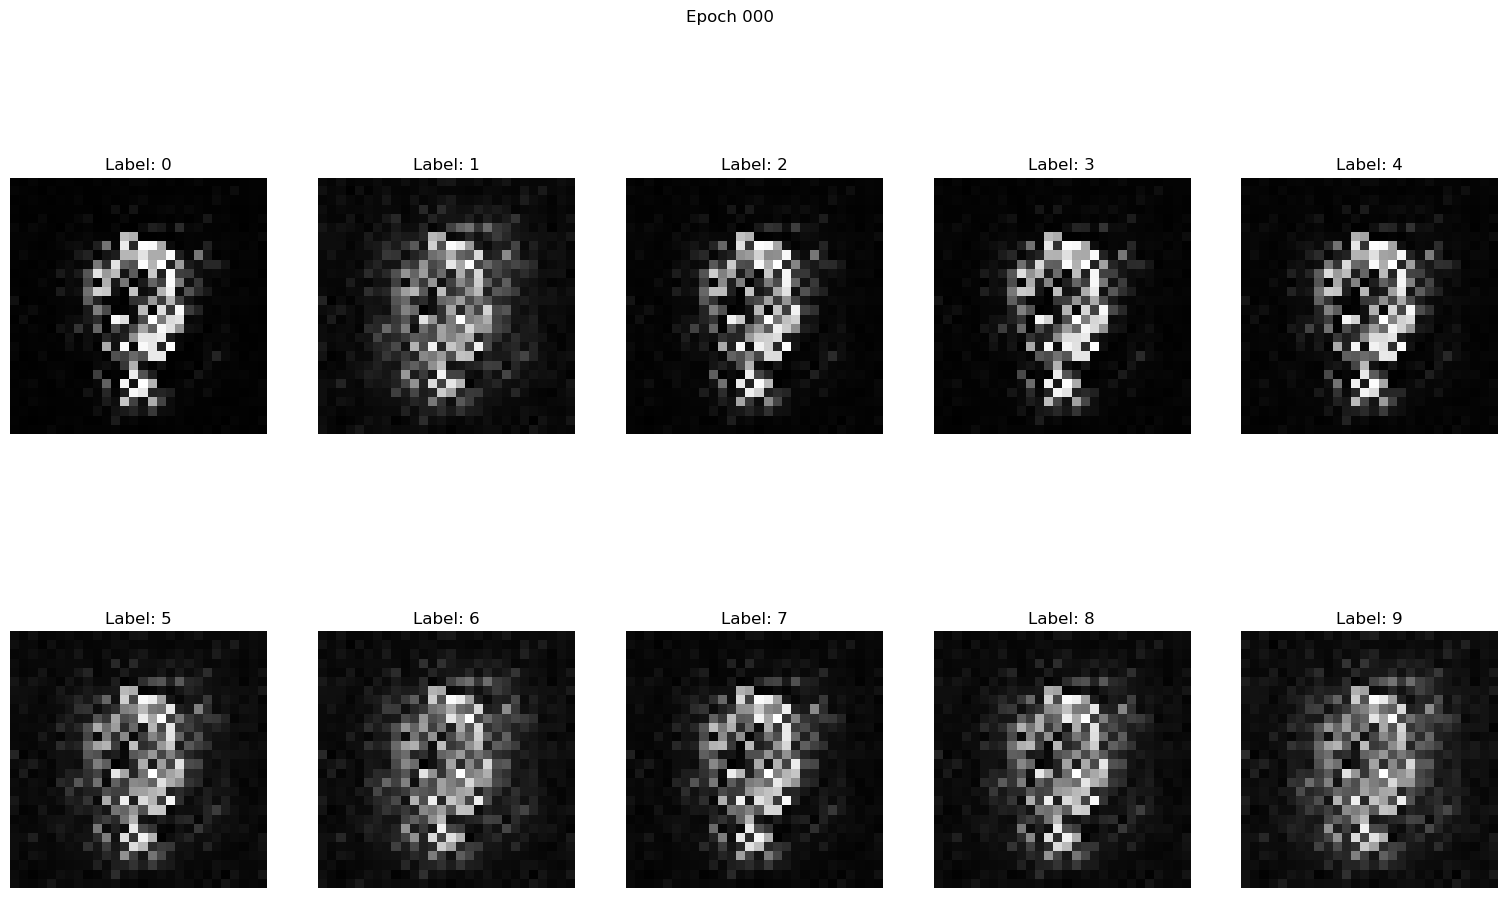

[Epoch 2/100] loss_D: 0.41804, loss_G: 2.68439, lr_D: 0.09531, lr_G:0.09531
[Epoch 3/100] loss_D: 0.39567, loss_G: 2.64798, lr_D: 0.09305, lr_G:0.09305
[Epoch 4/100] loss_D: 0.43111, loss_G: 2.85964, lr_D: 0.09085, lr_G:0.09085
[Epoch 5/100] loss_D: 0.24037, loss_G: 3.37356, lr_D: 0.08869, lr_G:0.08869
[Epoch 6/100] loss_D: 0.20830, loss_G: 3.74701, lr_D: 0.08659, lr_G:0.08659
[Epoch 7/100] loss_D: 0.18951, loss_G: 4.03820, lr_D: 0.08454, lr_G:0.08454
[Epoch 8/100] loss_D: 0.16465, loss_G: 4.44810, lr_D: 0.08253, lr_G:0.08253
[Epoch 9/100] loss_D: 0.16845, loss_G: 4.44846, lr_D: 0.08057, lr_G:0.08057
[Epoch 10/100] loss_D: 0.19317, loss_G: 4.05798, lr_D: 0.07866, lr_G:0.07866
[Epoch 11/100] loss_D: 0.25876, loss_G: 3.29174, lr_D: 0.07680, lr_G:0.07680
[Epoch 12/100] loss_D: 0.33241, loss_G: 2.55378, lr_D: 0.07498, lr_G:0.07498
[Epoch 13/100] loss_D: 0.37050, loss_G: 2.22565, lr_D: 0.07320, lr_G:0.07320
[Epoch 14/100] loss_D: 0.39598, loss_G: 2.02347, lr_D: 0.07146, lr_G:0.07146
[Epoch 

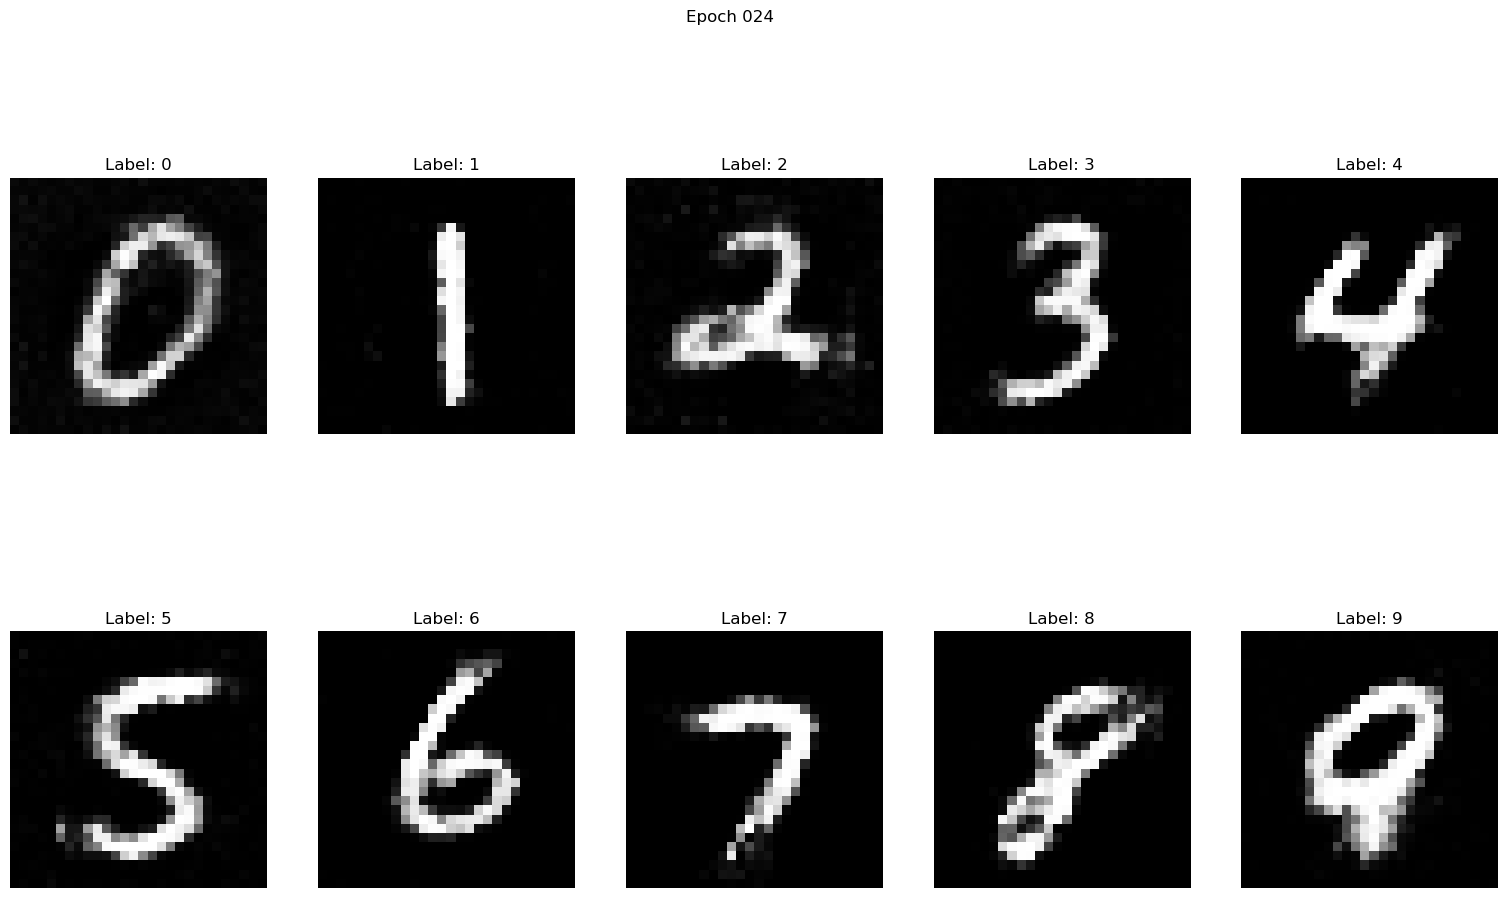

[Epoch 26/100] loss_D: 0.46995, loss_G: 1.61561, lr_D: 0.05358, lr_G:0.05358
[Epoch 27/100] loss_D: 0.47137, loss_G: 1.58849, lr_D: 0.05231, lr_G:0.05231
[Epoch 28/100] loss_D: 0.47507, loss_G: 1.58268, lr_D: 0.05107, lr_G:0.05107
[Epoch 29/100] loss_D: 0.47545, loss_G: 1.57332, lr_D: 0.04986, lr_G:0.04986
[Epoch 30/100] loss_D: 0.48304, loss_G: 1.55241, lr_D: 0.04868, lr_G:0.04868
[Epoch 31/100] loss_D: 0.48439, loss_G: 1.53576, lr_D: 0.04752, lr_G:0.04752
[Epoch 32/100] loss_D: 0.48362, loss_G: 1.54056, lr_D: 0.04639, lr_G:0.04639
[Epoch 33/100] loss_D: 0.48561, loss_G: 1.53885, lr_D: 0.04529, lr_G:0.04529
[Epoch 34/100] loss_D: 0.48933, loss_G: 1.51865, lr_D: 0.04422, lr_G:0.04422
[Epoch 35/100] loss_D: 0.48851, loss_G: 1.52764, lr_D: 0.04317, lr_G:0.04317
[Epoch 36/100] loss_D: 0.49043, loss_G: 1.51498, lr_D: 0.04215, lr_G:0.04215
[Epoch 37/100] loss_D: 0.48873, loss_G: 1.51627, lr_D: 0.04115, lr_G:0.04115
[Epoch 38/100] loss_D: 0.48933, loss_G: 1.51210, lr_D: 0.04017, lr_G:0.04017

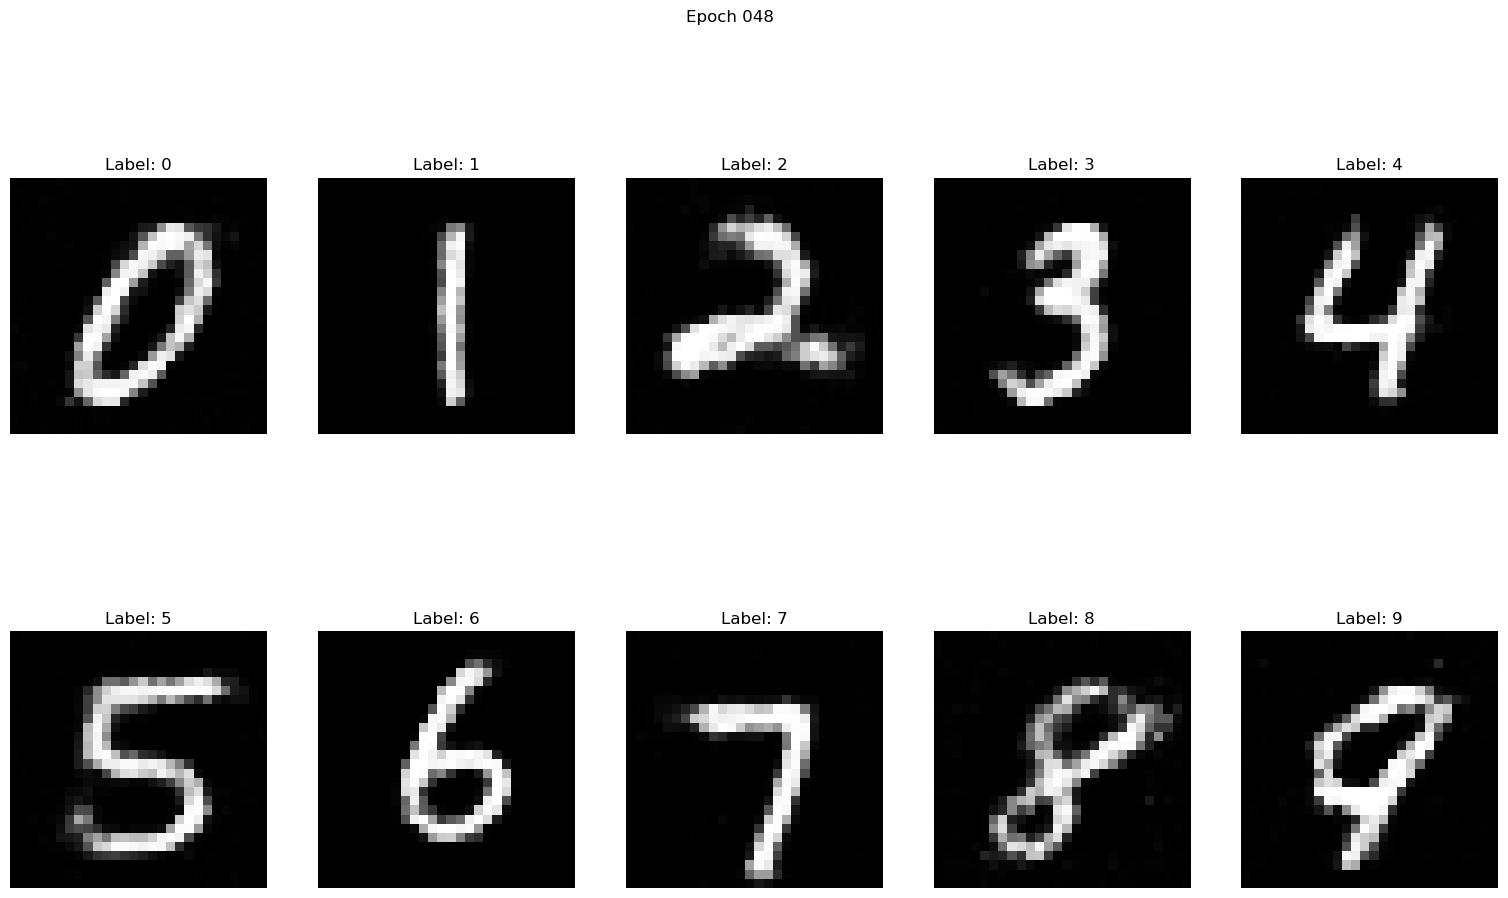

[Epoch 50/100] loss_D: 0.48007, loss_G: 1.53987, lr_D: 0.03012, lr_G:0.03012
[Epoch 51/100] loss_D: 0.47896, loss_G: 1.54062, lr_D: 0.02941, lr_G:0.02941
[Epoch 52/100] loss_D: 0.48012, loss_G: 1.54203, lr_D: 0.02871, lr_G:0.02871
[Epoch 53/100] loss_D: 0.47851, loss_G: 1.54582, lr_D: 0.02803, lr_G:0.02803
[Epoch 54/100] loss_D: 0.47805, loss_G: 1.54717, lr_D: 0.02736, lr_G:0.02736
[Epoch 55/100] loss_D: 0.47496, loss_G: 1.56299, lr_D: 0.02671, lr_G:0.02671
[Epoch 56/100] loss_D: 0.47313, loss_G: 1.56416, lr_D: 0.02608, lr_G:0.02608
[Epoch 57/100] loss_D: 0.47336, loss_G: 1.57665, lr_D: 0.02546, lr_G:0.02546
[Epoch 58/100] loss_D: 0.47083, loss_G: 1.57290, lr_D: 0.02486, lr_G:0.02486
[Epoch 59/100] loss_D: 0.46949, loss_G: 1.58283, lr_D: 0.02427, lr_G:0.02427
[Epoch 60/100] loss_D: 0.46987, loss_G: 1.58581, lr_D: 0.02369, lr_G:0.02369
[Epoch 61/100] loss_D: 0.47119, loss_G: 1.58582, lr_D: 0.02313, lr_G:0.02313
[Epoch 62/100] loss_D: 0.46770, loss_G: 1.59036, lr_D: 0.02258, lr_G:0.02258

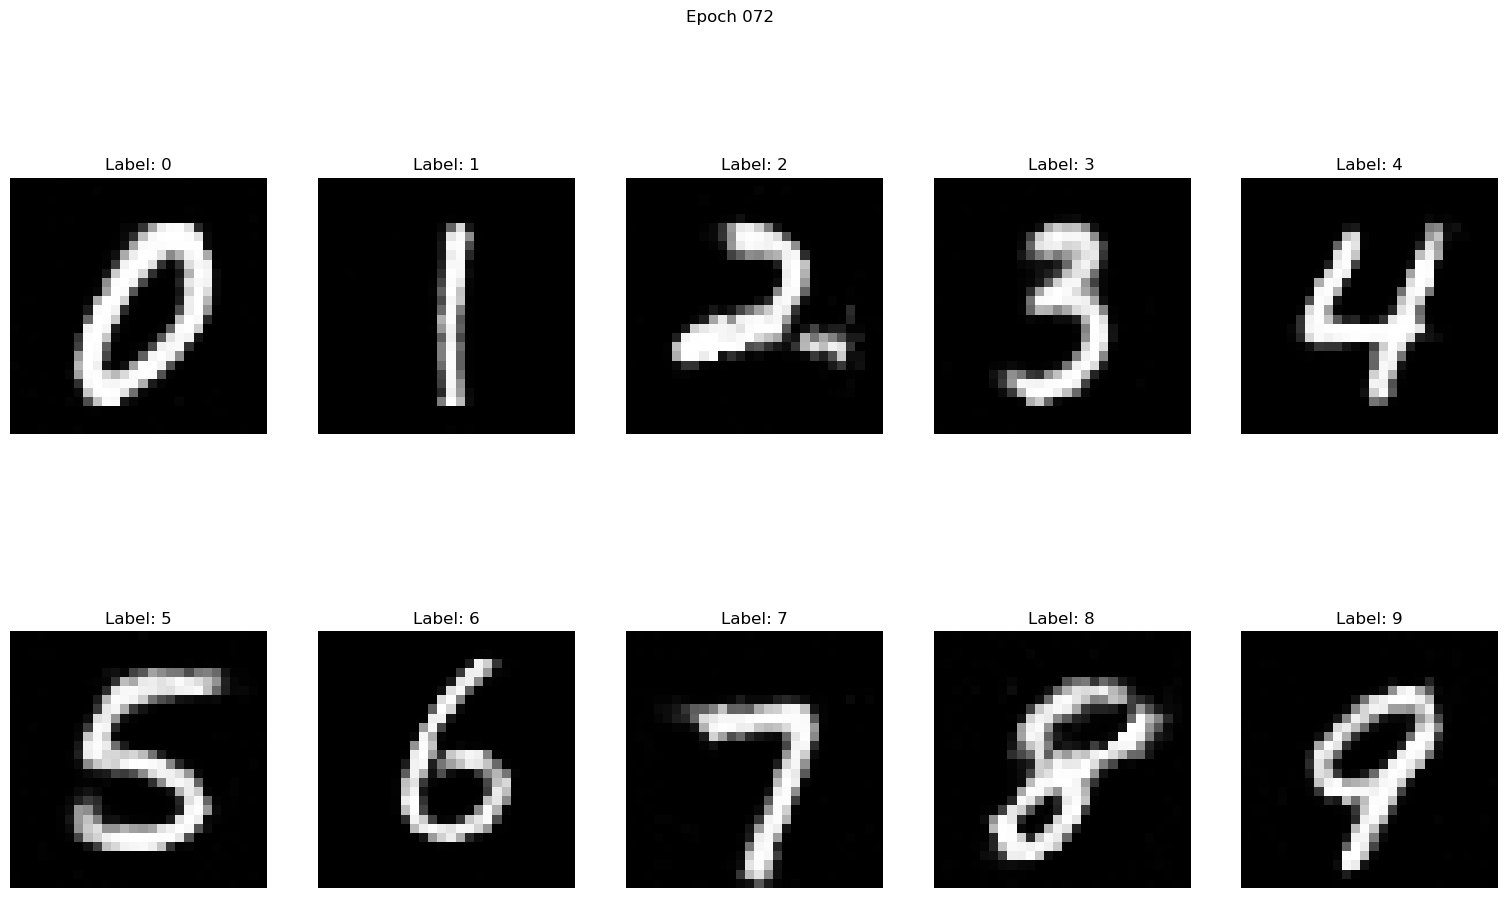

[Epoch 74/100] loss_D: 0.45653, loss_G: 1.63577, lr_D: 0.01693, lr_G:0.01693
[Epoch 75/100] loss_D: 0.45582, loss_G: 1.63893, lr_D: 0.01653, lr_G:0.01653
[Epoch 76/100] loss_D: 0.45366, loss_G: 1.64402, lr_D: 0.01614, lr_G:0.01614
[Epoch 77/100] loss_D: 0.45540, loss_G: 1.65527, lr_D: 0.01576, lr_G:0.01576
[Epoch 78/100] loss_D: 0.45178, loss_G: 1.65414, lr_D: 0.01538, lr_G:0.01538
[Epoch 79/100] loss_D: 0.45245, loss_G: 1.66297, lr_D: 0.01502, lr_G:0.01502
[Epoch 80/100] loss_D: 0.45111, loss_G: 1.67967, lr_D: 0.01466, lr_G:0.01466
[Epoch 81/100] loss_D: 0.44935, loss_G: 1.67141, lr_D: 0.01431, lr_G:0.01431
[Epoch 82/100] loss_D: 0.44989, loss_G: 1.67558, lr_D: 0.01397, lr_G:0.01397
[Epoch 83/100] loss_D: 0.44813, loss_G: 1.68397, lr_D: 0.01364, lr_G:0.01364
[Epoch 84/100] loss_D: 0.44758, loss_G: 1.69716, lr_D: 0.01332, lr_G:0.01332
[Epoch 85/100] loss_D: 0.44458, loss_G: 1.69142, lr_D: 0.01300, lr_G:0.01300
[Epoch 86/100] loss_D: 0.44627, loss_G: 1.70246, lr_D: 0.01270, lr_G:0.01270

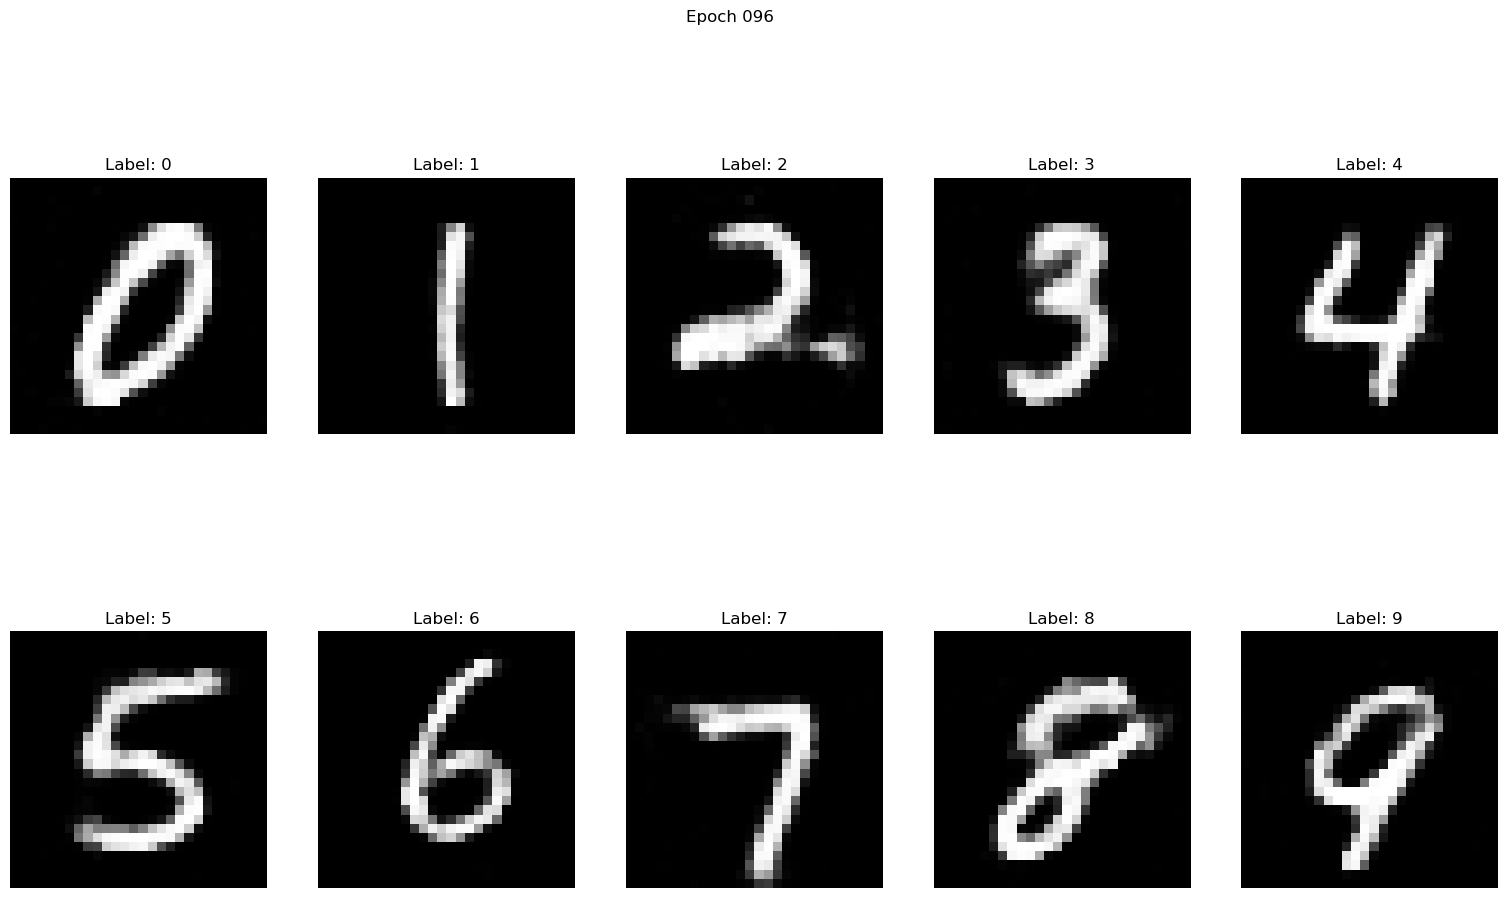

[Epoch 98/100] loss_D: 0.43317, loss_G: 1.76753, lr_D: 0.00952, lr_G:0.00952
[Epoch 99/100] loss_D: 0.43384, loss_G: 1.76028, lr_D: 0.00929, lr_G:0.00929
[Epoch 100/100] loss_D: 0.43328, loss_G: 1.77676, lr_D: 0.00907, lr_G:0.00907


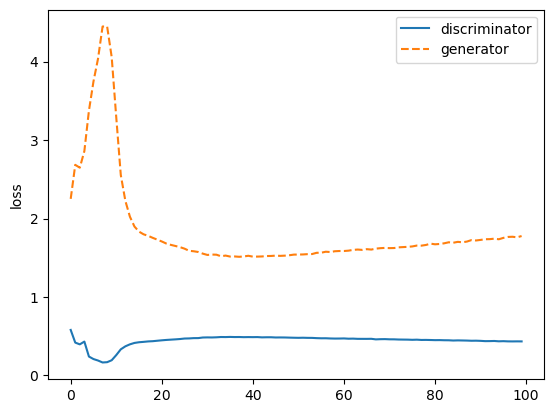

In [18]:
latent_dim = 100
generator = MnistGenerator(latent_dim=latent_dim)
discriminator = MnistDiscriminator()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


lr_D = 0.1
lr_G = 0.1
# num_epochs = 480
num_epochs = 100
print_every = 150
visualize_each = 24

fixed_noise = torch.normal(0., 1., size=(10, latent_dim))
fixed_label = torch.cat([one_hot(i).view(1,-1) for i in range(10)], dim=0)


train_gan(device=device, D=discriminator, G=generator, dataloader=dataloader, num_epochs=num_epochs,
          lr_G=lr_G, lr_D=lr_D, latent_dim=latent_dim, fixed_noise=fixed_noise, fixed_label=fixed_label,
          visualize=True, print_every=print_every, visualize_each=visualize_each)